In [11]:
import gym

import random
from collections import defaultdict
import numpy as np

# this is all plotting stuff :/
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MaxNLocator
%matplotlib inline

matplotlib.style.use('ggplot')

In [5]:
env = gym.make('Blackjack-v0')

In [6]:
episodes = 500000
gamma = 1

In [7]:
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    
    best_action = np.argmax(Q[state])
        
    epsilon = get_epsilon(state_count)
    
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

In [8]:
def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        
        done = False
        while not done:
            action = np.argmax(Q[state])
            
            state, reward, done, _ = env.step(action=action)
            
        if reward > 0:
            wins += 1
        
    return wins / episodes

In [9]:
def monte_carlo(gamma=1., episodes=5000, evaluate=False):

    # this is our value function, we will use it to keep track of the "value" of being in a given state
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # to decide what action to take and calculate epsilon we need to keep track of how many times we've
    # been in a given state and how often we've taken a given action when in that state
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)

    # for keeping track of our policy evaluations (we'll plot this later)
    evaluations = []

    for i in range(episodes):
        # evaluating a policy is slow going, so let's only do this every 1000 games
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
    
        # to update our value function we need to keep track of what states we were in and what actions
        # we took throughout the game
        episode = []
    
        # lets start a game!
        state = env.reset()
        done = False
    
        # and keep playing until it's done (recall this is something Gym will tell us)
        while not done:
            # so we're in some state, let's remember we've been here and pick an action using our
            # function defined above
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)

            # when we take that action, recall Gym will give us a new state, some reward and if we are done
            new_state, reward, done, _ = env.step(action=action)
        
            # save what happened, we're just going to keep the state, action and reward
            episode.append((state, action, reward))
        
            state = new_state

        # at this point the game is finished, we either won or lost
        # so we need to take what happened and update our value function
        G = 0
    
        # because you can only win or lose a game of blackjack we only get a reward at the end of the game
        # (+1 for a win, 0 for a draw, -1 for a loss). So let's start at the end of the game and work
        # backwards through our states to decide how good it was to be in a state
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            
            # we need some way of deciding how the game we just played impacted our value function. The
            # standard approach here is to take the reward(s) we got playing over multiple games and
            # taking the mean. We can update the mean as we go using what is known as incremental averaging
            # https://math.stackexchange.com/questions/106700/incremental-averageing
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
            
    return Q, evaluations

In [13]:
Q_mc, evaluations = monte_carlo(episodes=500000, evaluate=True)

In [20]:
def plot_value_function(Q, title="Value Function"):
    V = defaultdict(float)

    for state, action_rewards in Q.items():
        r1, r2 = action_rewards
        action_value = np.max([r1, r2])
        V[state] = action_value
    
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(title)
        ax.view_init(ax.elev, 120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "value function")
    plot_surface(X, Y, Z_ace, "value function - usable ace")

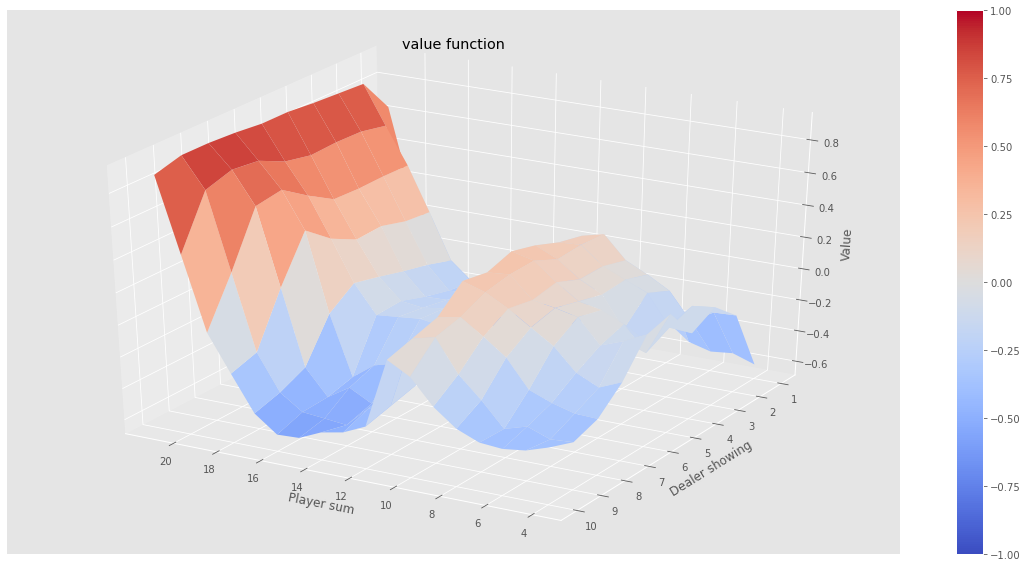

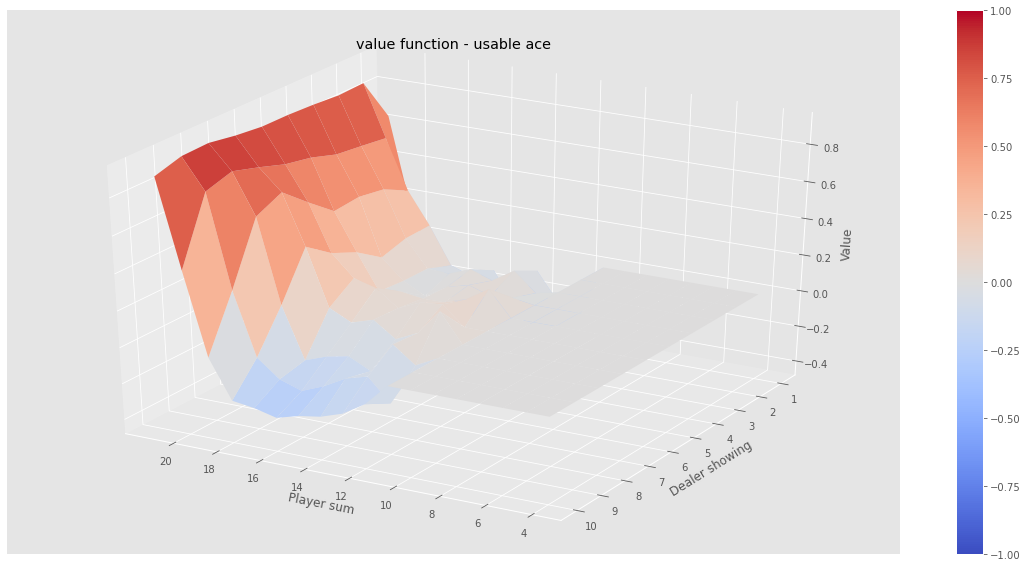

In [21]:
plot_value_function(Q_mc)